In [1]:
#import cac thu vien can thiet


import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

In [2]:
#load data
def load_data_from_local(data_path):
    #Ham doc du lieu tu thu muc local
    #Input: data_path
    #Output:list chua noi dung van ban va list chua cac label (0-19)
    texts = []
    labels = []
    
    # Lay danh sach ten cac folder
    # Vi du: folder_names = ['alt.atheism', 'comp.graphics', ...]
    try:
        folder_names = sorted(os.listdir(data_path))
    except FileNotFoundError:
        print(f"Loi khong thay file '{data_path}'")
        return [], [], {}

    # Tao tu dien tu ten qua so 
    label_map = {name: i for i, name in enumerate(folder_names)}
    
    print(f"Dang doc du lieu tu {len(folder_names)} thu muc...")
    
    count = 0
    for folder in folder_names:
        folder_path = os.path.join(data_path, folder)
        
        # Kiem tra xem co pahi la thu muc khong
        if not os.path.isdir(folder_path):
            continue
            
        label_id = label_map[folder]
        
        # Duyet qua tung file trong thu muc
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            
            try:
                # Du lieu 20 news group 
                with open(file_path, 'r', encoding='latin1') as f:
                    content = f.read()
                    texts.append(content)
                    labels.append(label_id)
                    count += 1
            except Exception as e:
                print(f"Loi doc file {filename}: {e}")

    print(f"Da doc xong {count} files.")
    return texts, labels, label_map


mypath = './twenty+newsgroups/20_newsgroups' 

# Load du lieu
X_raw_text, y_raw_labels, class_names = load_data_from_local(mypath)

# Kiem tra dau ra
if len(X_raw_text) > 0:
    print(f"Vi du van ban dau tien thuoc lop {y_raw_labels[0]} ({list(class_names.keys())[y_raw_labels[0]]}):")
    print(X_raw_text[0][:200]) # In 200 ky tu dau

Dang doc du lieu tu 20 thu muc...
Da doc xong 19997 files.
Vi du van ban dau tien thuoc lop 0 (alt.atheism):
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usenet.ins.cwru.edu!po.CWRU.edu!kmr4
From: kmr4@po.CWRU.edu (Keith M. Ryan)
Newsgr


In [3]:
# Tao bo dem
bow = CountVectorizer(max_features=2000)
# Bien doi text -> vetor dem 
X_bow = bow.fit_transform(X_raw_text).toarray()
print(X_bow.shape)


# Tao bo tinh TF-IDF
tfidf = TfidfVectorizer(max_features=2000)
# Bien doi text -> vector tfidf
X_tfidf = tfidf.fit_transform(X_raw_text).toarray()
print(X_tfidf.shape)

X_tensor_bow = torch.tensor(X_bow, dtype=torch.float32)
X_tensor_tfidf = torch.tensor(X_tfidf, dtype=torch.float32)
print(type(X_tensor_bow))
print(type(X_tensor_tfidf))


(19997, 2000)
(19997, 2000)
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [4]:
#bien cac label thanh tensor de feed vao duoc mang MLP
y = torch.tensor(y_raw_labels, dtype=torch.long)
print(y.shape)

torch.Size([19997])


In [5]:
#chia tap train,test
#day la neu dung tfidf
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tensor_tfidf, y, test_size=0.2, random_state=42)
print(X_train_tfidf.shape,X_test_tfidf.shape)
#day la neu dung bow
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_tensor_bow, y, test_size=0.2, random_state=42)
print(X_train_bow.shape,X_test_bow.shape)

torch.Size([15997, 2000]) torch.Size([4000, 2000])
torch.Size([15997, 2000]) torch.Size([4000, 2000])


In [6]:
D_in = X_train_tfidf.shape[1]  # so features cua input 
N1 = 64                  # So node layer 1
N2 = 32                  # So node layer 2
D_out = 20               # so node output


#khoi tao trong so ngau nhien 

W1 = torch.randn(D_in, N1) /np.sqrt(D_in)
W1.requires_grad=True
b1 = torch.zeros(N1, requires_grad=True)

W2 = torch.randn(N1, N2) / np.sqrt(N1)
W2.requires_grad=True
b2 = torch.zeros(N2, requires_grad=True)

W3 = torch.randn(N2, D_out) / np.sqrt(N2)
W3.requires_grad=True
b3 = torch.zeros(D_out, requires_grad=True)

In [ ]:
#cac ham de su dung trong qua trinh train
def relu(x):
    return torch.maximum(torch.tensor(0.0),x)
def leaky_relu(x):
    return torch.maximum(0.01*x,x)

def softmax(x):
    exp_x = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
    return exp_x / torch.sum(exp_x, dim=1, keepdim=True)

def cross_entropy_loss(y_pred, y_true):
    n= y_true.shape[0]
    log_like_hood = -torch.log(y_pred[range(n),y_true]+1e-9)
    loss= torch.sum(log_like_hood) /n
    return loss

def accuracy(y_pred, y_true):
    prediction = torch.argmax(y_pred,dim =1)
    correct = (prediction==y_true).float().sum()torch.tensor(0.0)
    return correct/y_true.shape[0]






In [8]:
epochs = 2500
learning_rate = 0.1
loss_history_bow = []
acc_history_bow = []
loss_history_tfidf = []
acc_history_tfidf = []

#train cho data bow truoc
for epoch in range(epochs):
    #feed foward
    z1 = X_train_bow @ W1 +b1
    a1 = leaky_relu(z1)
    
    z2 = a1 @ W2 + b2
    a2 = leaky_relu(z2)
    
    z3 = a2 @ W3 +b3
    
    y_pred = softmax(z3)
    
    #tinh loss va backprogation
    loss = cross_entropy_loss(y_pred, y_train_bow)
    loss.backward()
    
    #tat tinh toan grad
    with torch.no_grad(): 
        #update cac he so
        W1 -= learning_rate * W1.grad
        b1 -= learning_rate * b1.grad
        W2 -= learning_rate * W2.grad
        b2 -= learning_rate * b2.grad
        W3 -= learning_rate * W3.grad
        b3 -= learning_rate * b3.grad
        
        #reset grad ve 0 khong thi tai cac epoch sau se cong don
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        W3.grad.zero_()
        b3.grad.zero_()
        

    
    if epoch % 100 ==0 :
        print("loss tai lan thu",epoch,"la",loss.item(),"acc la:",accuracy(y_pred,y_train_bow).item())
        loss_history_bow.append(loss.item())
        acc_history_bow.append(accuracy(y_pred,y_train_bow).item())

print("training da xong bow")


####################################
#train cho data tfidf sau
for epoch in range(epochs):
    #feed foward
    z1 = X_train_tfidf @ W1 +b1
    a1 = leaky_relu(z1)
    
    z2 = a1 @ W2 + b2
    a2 = leaky_relu(z2)
    
    z3 = a2 @ W3 +b3
    
    y_pred = softmax(z3)
    
    #tinh loss va backprogation
    loss = cross_entropy_loss(y_pred, y_train_tfidf)
    loss.backward()
    
    #tat tinh toan grad
    with torch.no_grad(): 
        #update cac he so
        W1 -= learning_rate * W1.grad
        b1 -= learning_rate * b1.grad
        W2 -= learning_rate * W2.grad
        b2 -= learning_rate * b2.grad
        W3 -= learning_rate * W3.grad
        b3 -= learning_rate * b3.grad
        
        #reset grad ve 0 khong thi tai cac epoch sau se cong don
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        W3.grad.zero_()
        b3.grad.zero_()
        

    
    if epoch % 100 ==0 :
        print("loss tai lan thu",epoch,"la",loss.item(),"acc la:",accuracy(y_pred,y_train_tfidf).item())
        loss_history_tfidf.append(loss.item())
        acc_history_tfidf.append(accuracy(y_pred,y_train_tfidf).item())

print("training da xong tfidf")






    

loss tai lan thu 0 la 3.1130905151367188 acc la: 0.0473213717341423
loss tai lan thu 100 la 1.5491752624511719 acc la: 0.589798092842102
loss tai lan thu 200 la 0.48666998744010925 acc la: 0.884540855884552
loss tai lan thu 300 la 0.2354368269443512 acc la: 0.9452397227287292
loss tai lan thu 400 la 0.20454049110412598 acc la: 0.9435518980026245
loss tai lan thu 500 la 0.1184045672416687 acc la: 0.9646808505058289
loss tai lan thu 600 la 0.09782867878675461 acc la: 0.9683065414428711
loss tai lan thu 700 la 0.08504512161016464 acc la: 0.9699318408966064
loss tai lan thu 800 la 0.07549833506345749 acc la: 0.9720572829246521
loss tai lan thu 900 la 0.0684889629483223 acc la: 0.9733074903488159
loss tai lan thu 1000 la 0.06308282911777496 acc la: 0.9742451906204224
loss tai lan thu 1100 la 0.05862508341670036 acc la: 0.9749953150749207
loss tai lan thu 1200 la 0.057063497602939606 acc la: 0.9749953150749207
loss tai lan thu 1300 la 0.05315158888697624 acc la: 0.9754953980445862
loss tai l

In [9]:
def display(data):
        
    epochs = [i * 100 for i in range(len(loss_history_bow))]
        
    plt.figure(figsize=(10, 6)) # kich thuoc diagram
        
    # Ve duong loss la cac cham do
    plt.plot(epochs, data, color='red', marker='o', linestyle='-', linewidth=2, markersize=4, label='Training Acc')
    
    
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7) #Ke luoi mo 
    plt.legend() #Hien chu thichs

    plt.show()

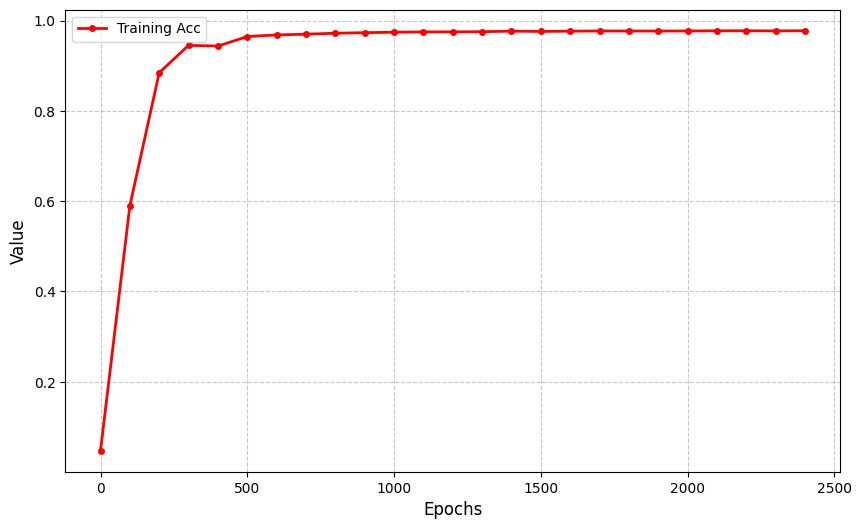

In [10]:
display(acc_history_bow)

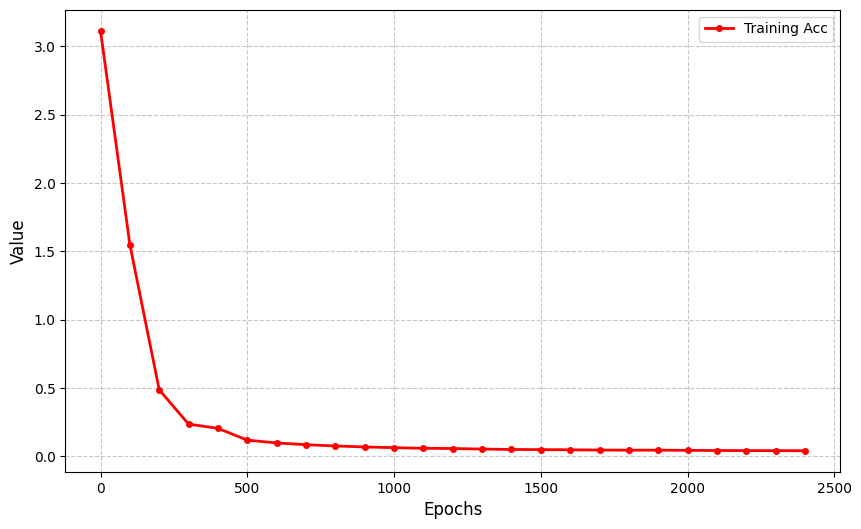

In [11]:
display(loss_history_bow)

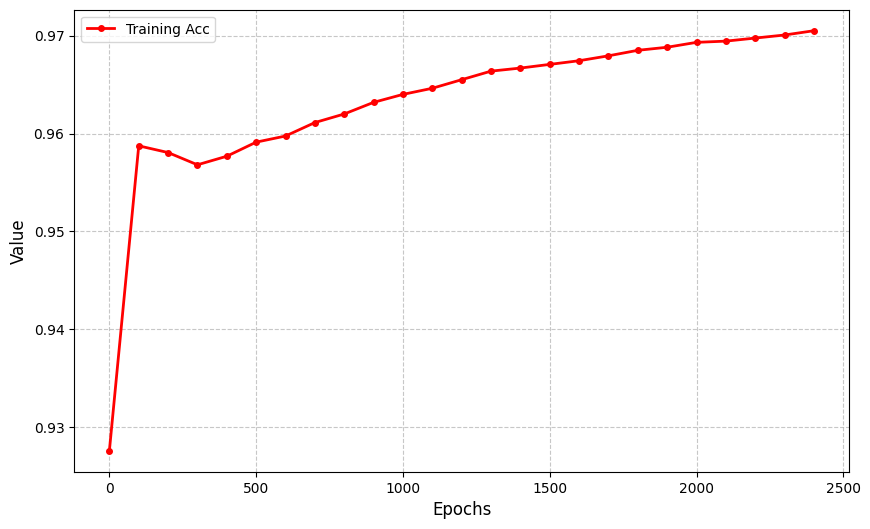

In [12]:
display(acc_history_tfidf)

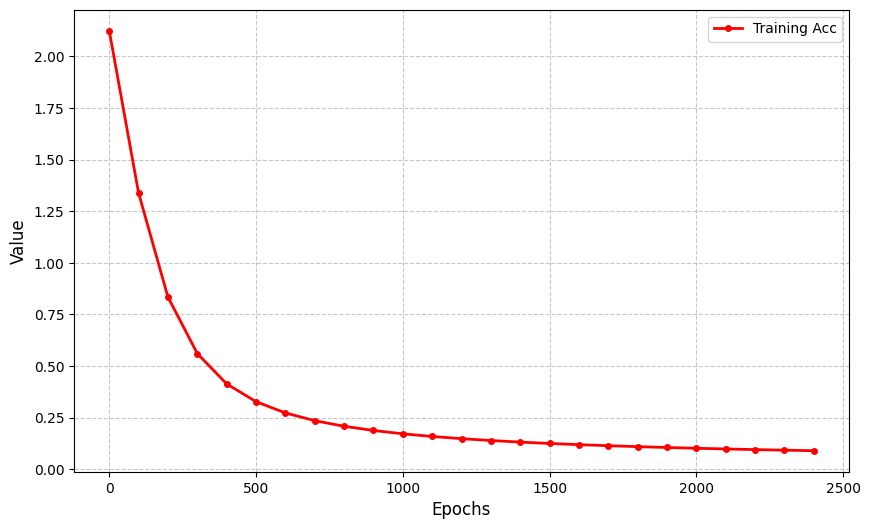

In [13]:
display(loss_history_tfidf)

In [14]:
#thuc hien test tren test data
#bow
z1 = X_test_bow @ W1 +b1
a1 = leaky_relu(z1)
    
z2 = a1 @ W2 + b2
a2 = leaky_relu(z2)
    
z3 = a2 @ W3 +b3
    
y_pred = softmax(z3)

print("accuracy tren tap test bow la:",accuracy(y_pred,y_test_bow).item()*100)

#tfidf
z1 = X_test_tfidf @ W1 +b1
a1 = leaky_relu(z1)
    
z2 = a1 @ W2 + b2
a2 = leaky_relu(z2)
    
z3 = a2 @ W3 +b3
    
y_pred = softmax(z3)

print("accuracy tren tap test tfidf la:",accuracy(y_pred,y_test_tfidf).item()*100)

accuracy tren tap test bow la: 87.74999976158142
accuracy tren tap test tfidf la: 94.84999775886536


In [15]:
def predict_new_text(text):
    # 1. Xy ly giong luc train
    text_vec = tfidf.transform([text]).toarray()
    x_input = torch.tensor(text_vec, dtype=torch.float32)
    
    # 2. Feed foward
    with torch.no_grad():
        z1 = x_input @ W1 + b1
        a1 = leaky_relu(z1)
        z2 = a1 @ W2 + b2
        a2 = leaky_relu(z2)
        z3 = a2 @ W3 + b3
        y_prob = softmax(z3)
    
    # 3. Lay ket qua
    conf, pred_id = torch.max(y_prob, dim=1)
    
    # Anh xa tu label qua ten
    id_to_name = {v: k for k, v in class_names.items()}
    
    print(f"Input: '{text}'")
    print(f"Dự đoán: {id_to_name[pred_id.item()]}")
    print(f"Độ tin cậy: {conf.item()*100:.2f}%")

# Test
predict_new_text("The computer graphics card is powerful.")
predict_new_text("God and religion are important topics.")
predict_new_text("orbit")

Input: 'The computer graphics card is powerful.'
Dự đoán: comp.graphics
Độ tin cậy: 100.00%
Input: 'God and religion are important topics.'
Dự đoán: talk.religion.misc
Độ tin cậy: 92.57%
Input: 'orbit'
Dự đoán: sci.space
Độ tin cậy: 86.62%
